# Vaccinatie-/Misinformatie-Classifier
## ...

(hier komt wat uitleg waar dit over gaat en wat het is).


In [111]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.externals import joblib
import scipy
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import numpy as np
import glob
import os
from collections import Counter
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from string import punctuation
import eli5
import pandas as pd

STOPWORDS = get_stop_words('dutch')
SEED = 20092016

### 1. Define functions for preprocessing and data retrieval

In [2]:
def preprocess(doc):
    if type(doc) is str:
        doc = doc.lower()
        doc = doc.translate(str.maketrans({key: " " for key in string.punctuation}))
        doc = " ".join([w for w in doc.split() if w not in STOPWORDS])
        return doc
    else:
        print('Received non-string input, returning empty string')
        return ''

In [7]:
def get_traintest(df, test_size=.30):
    '''takes dataframe, selects relevant part, preprocesses text and returns train, test data lists with 
    (text, label) tuples'''
    rows = df[['Platte tekst (zonder opmaak)','Misinfo Nee(1) Ja(0)']].dropna().to_records(index=False)
    rowsclean = []
    for e in rows:
        try:
            rowsclean.append((preprocess(e[0]), abs(int(e[1])-1)))  # we now code misinfo as 1 and legitimate as 0
        except ValueError:
            pass
    if test_size < 1:
        train, test = train_test_split(rowsclean, test_size=test_size, random_state=SEED)
        return train, test
    if test_size == 1:
        return [], rowsclean


### 2. Read data

We have two datasets: one on childhood vaccination on which we train and test, and one on HPV that we use for testing out-of-sample prediction only

In [89]:
hpv = pd.read_csv('hpv_dedup.csv')
childhood = pd.read_csv('childhood_dedup.csv')

In [11]:
childhood_train, childhood_test = get_traintest(childhood)
print("Obtained {} train and {} test tuples for childhood vaccination".format(len(childhood_train), len(childhood_test)))

hpv_train, hpv_test = get_traintest(hpv, test_size=1)
print("Obtained {} train and {} test tuples for HPV".format(len(hpv_train), len(hpv_test)))

Obtained 309 train and 133 test tuples for childhood vaccination
Obtained 0 train and 198 test tuples for HPV


In [91]:
### Cross-validation instead of train-test
_, childhooddata = get_traintest(childhood, test_size=1)
print("Obtained {} tuples for childhood vaccination".format(len(childhooddata)))

Obtained 442 tuples for childhood vaccination


### 3. Define Machine Learning-functions

In [13]:
def performance(predictions, actual_scores):
    accuracy=metrics.accuracy_score(actual_scores,predictions,normalize=True)
    recall_misinfo=metrics.recall_score(actual_scores,predictions,pos_label=1)
    recall_legitimate=metrics.recall_score(actual_scores,predictions,pos_label=0)
    precision_misinfo=metrics.precision_score(actual_scores,predictions,pos_label=1)
    precision_legitimate=metrics.precision_score(actual_scores,predictions,pos_label=0)
    confusionmatrix=metrics.confusion_matrix(actual_scores,predictions)
    print('Accuracy:',accuracy,
          '\nRecall (misinfo):',recall_misinfo,
          '\nPrecision (misinfo):',precision_misinfo,
          '\nRecall (legitimate):',recall_legitimate,
          '\nPrecision (legitimate) ',precision_legitimate,
          '\nConfusion Matrix:','\n',confusionmatrix)


In [14]:
def roc_curve(predicted_probabilities, actual_scores):
    fpr, tpr, thresholds = metrics.roc_curve(actual_scores, predicted_probabilities[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC:\n{}".format(roc_auc))
    #%%
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [15]:
def get_optimal_threshold(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]    # return threshold score of the last (i.e., highest j_score)_ot

In [25]:
def get_conf_int(arr, percentage=.9):
    """Finds the confidence interval range for the given array input."""

    return scipy.stats.t.interval(percentage, len(arr)-1, loc=np.mean(arr), scale=scipy.stats.sem(arr))


def execute_model(df, var_y, var_x, vectorizer, model, iters=20, cv=5, n_jobs=1):
    """Runs the cross-validated classification model with given parameters."""

    df_temp = df[[var_y, var_x]].dropna()
    df_temp[var_y] = df_temp[var_y].apply(int)
    X, y = df_temp[var_x], df_temp[var_y]
    X_vector = vectorizer.fit_transform(X)
    scores = []
    for i in range(iters):
        scores = [*scores, *cross_val_score(model, X_vector, y, cv=cv, n_jobs=n_jobs)]
    conf_int = get_conf_int(scores)
    return np.mean(scores), conf_int

In [200]:
# zo kunnen we dus cross validation doen zoals de reviewer vraagt

def get_scores(pipe):
    precision_legitimate = metrics.make_scorer(metrics.precision_score, greater_is_better=True,  pos_label=0)
    precision_misinfo = metrics.make_scorer(metrics.precision_score, greater_is_better=True,  pos_label=1)
    recall_legitimate = metrics.make_scorer(metrics.recall_score, greater_is_better=True,  pos_label=0)
    recall_misinfo = metrics.make_scorer(metrics.recall_score, greater_is_better=True,  pos_label=1)
    f1_legitimate = metrics.make_scorer(metrics.f1_score, greater_is_better=True,  pos_label=0)
    f1_misinfo = metrics.make_scorer(metrics.f1_score, greater_is_better=True,  pos_label=1)
    results = []
    pipename = [e[0] for e in pipe.steps]
    pipename.reverse()
    for scoring in [f1_legitimate,recall_legitimate, precision_legitimate, f1_misinfo, recall_misinfo, precision_misinfo]:
        _scoring, _label =  scoring.__repr__()[12:-1].split(', ')
        metricname = _scoring[:_scoring.find('_')]
        target =  _label[-1:].replace("0","legitimate").replace("1","misinformation")
        scores = cross_val_score(pipe, [r[0] for r in childhooddata], [r[1] for r in childhooddata], scoring=scoring)
        cilower, ciupper = get_conf_int(scores)
        print(f"{metricname}, {target}: M = {np.mean(scores):.2f}, SD = {np.std(scores):.2f}, 90% CI = [{cilower:.2f}, {ciupper:.2f}]")
        results.append({'classifier': " with ".join(pipename), 'target':target, 'metric':metricname, 'M': np.mean(scores), 'SD': np.std(scores), 'CI-lower':cilower, 'CI-upper':ciupper})
    return pd.DataFrame(results)

### Naive Bayes (count)

Accuracy: 0.8345864661654135 
Recall (misinfo): 0.7580645161290323 
Precision (misinfo): 0.8703703703703703 
Recall (legitimate): 0.9014084507042254 
Precision (legitimate)  0.810126582278481 
Confusion Matrix: 
 [[64  7]
 [15 47]]
ROC AUC:
0.9311676510676966


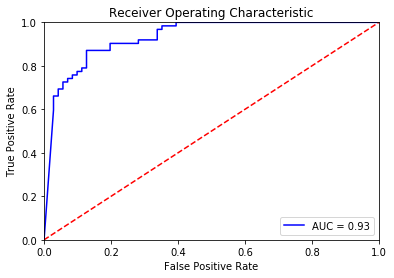

In [194]:
vec = CountVectorizer()
clf = MultinomialNB()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

In [201]:
nbcountscores = get_scores(pipe)

f1, legitimate: M = 0.91, SD = 0.03, 90% CI = [0.88, 0.94]
recall, legitimate: M = 0.92, SD = 0.05, 90% CI = [0.87, 0.98]
precision, legitimate: M = 0.90, SD = 0.07, 90% CI = [0.83, 0.97]
f1, misinformation: M = 0.86, SD = 0.06, 90% CI = [0.80, 0.92]
recall, misinformation: M = 0.84, SD = 0.12, 90% CI = [0.72, 0.96]
precision, misinformation: M = 0.89, SD = 0.06, 90% CI = [0.83, 0.96]


In [202]:
nbcountscores

,classifier,target,metric,M,SD,CI-lower,CI-upper
0,multinomialnb with countvectorizer,legitimate,f1,0.907551,0.028468,0.877206,0.937896
1,multinomialnb with countvectorizer,legitimate,recall,0.923002,0.051517,0.868088,0.977915
2,multinomialnb with countvectorizer,legitimate,precision,0.898649,0.065970,0.828330,0.968969
3,multinomialnb with countvectorizer,misinformation,f1,0.859390,0.057108,0.798518,0.920262
4,multinomialnb with countvectorizer,misinformation,recall,0.841441,0.115565,0.718258,0.964625
5,multinomialnb with countvectorizer,misinformation,precision,0.893632,0.060660,0.828972,0.958291


### Naive Bayes (tfidf)

Accuracy: 0.6165413533834586 
Recall (misinfo): 0.1774193548387097 
Precision (misinfo): 1.0 
Recall (legitimate): 1.0 
Precision (legitimate)  0.5819672131147541 
Confusion Matrix: 
 [[71  0]
 [51 11]]
ROC AUC:
0.9118582462517038


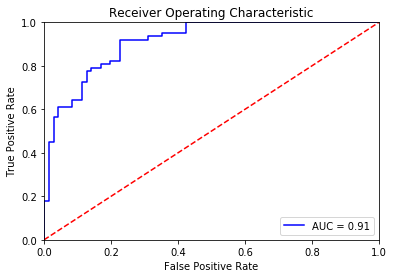

In [203]:
vec = TfidfVectorizer()
clf = MultinomialNB()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

In [204]:
nbtfidfscores = get_scores(pipe)

f1, legitimate: M = 0.82, SD = 0.04, 90% CI = [0.78, 0.87]
recall, legitimate: M = 0.99, SD = 0.02, 90% CI = [0.98, 1.01]
precision, legitimate: M = 0.70, SD = 0.06, 90% CI = [0.64, 0.77]
f1, misinformation: M = 0.54, SD = 0.16, 90% CI = [0.37, 0.71]
recall, misinformation: M = 0.39, SD = 0.17, 90% CI = [0.22, 0.57]
precision, misinformation: M = 0.98, SD = 0.04, 90% CI = [0.93, 1.02]


### Logistic Regression (count)

Accuracy: 0.8045112781954887 
Recall (misinfo): 0.6612903225806451 
Precision (misinfo): 0.8913043478260869 
Recall (legitimate): 0.9295774647887324 
Precision (legitimate)  0.7586206896551724 
Confusion Matrix: 
 [[66  5]
 [21 41]]
ROC AUC:
0.9357110404361655


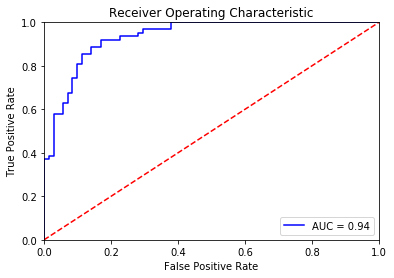

In [205]:
vec = CountVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

In [206]:
logregcountscores = get_scores(pipe)

f1, legitimate: M = 0.89, SD = 0.03, 90% CI = [0.87, 0.92]
recall, legitimate: M = 0.93, SD = 0.05, 90% CI = [0.88, 0.98]
precision, legitimate: M = 0.87, SD = 0.06, 90% CI = [0.81, 0.93]
f1, misinformation: M = 0.83, SD = 0.06, 90% CI = [0.76, 0.90]
recall, misinformation: M = 0.79, SD = 0.12, 90% CI = [0.67, 0.92]
precision, misinformation: M = 0.89, SD = 0.05, 90% CI = [0.84, 0.95]


In [207]:
grid = {
    'logisticregression__C' : [1, 100, 1e4,1e6],
    'logisticregression__penalty' : ['l1', 'l2','elasticnet'],
    'logisticregression__solver': ['liblinear', 'lbfgs','saga']
}
search = GridSearchCV(estimator=pipe,
                     param_grid=grid,
                     scoring=scoring,
                     cv=5)
search.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])
print('Using these hyperparameters {}, we get the best performance:'.format(search.best_params_))
#print(metrics.classification_report(y_test, search.predict(X_test)))



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/pyt

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estim

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

Using these hyperparameters {'logisticregression__C': 1000000.0, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}, we get the best performance:


In [208]:
#scores = search.score([r[0] for r in childhood_train], [r[1] for r in childhood_train])
#ciupper, cilower = get_conf_int(scores)
#print(f"{scoring}: M = {np.mean(scores):.2f}, SD = {np.std(scores):.2f}, 90% CI = [{ciupper:.2f}, {cilower:.2f}]")

In [209]:
#search.cv_results_['mean_test_score']

In [210]:
#search.cv_results_['std_test_score']

In [211]:
#import pandas as pd
#pd.DataFrame(search.cv_results_['params'], search.cv_results_['mean_test_score'])

### Logistic Regression (tfidf)

Accuracy: 0.7593984962406015 
Recall (misinfo): 0.5161290322580645 
Precision (misinfo): 0.9411764705882353 
Recall (legitimate): 0.971830985915493 
Precision (legitimate)  0.696969696969697 
Confusion Matrix: 
 [[69  2]
 [30 32]]
ROC AUC:
0.9477510222626079


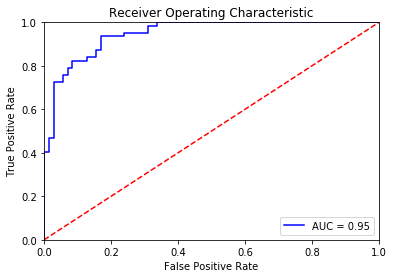

In [212]:
vec = TfidfVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])
predicted_probabilities = pipe.predict_proba([r[0] for r in childhood_test])

performance(predictions, [e[1] for e in childhood_test])
roc_curve(predicted_probabilities, [e[1] for e in childhood_test])

In [213]:
logregtfidfscores = get_scores(pipe)

f1, legitimate: M = 0.90, SD = 0.04, 90% CI = [0.86, 0.94]
recall, legitimate: M = 0.98, SD = 0.03, 90% CI = [0.95, 1.01]
precision, legitimate: M = 0.84, SD = 0.07, 90% CI = [0.76, 0.91]
f1, misinformation: M = 0.81, SD = 0.11, 90% CI = [0.69, 0.92]
recall, misinformation: M = 0.72, SD = 0.15, 90% CI = [0.56, 0.88]
precision, misinformation: M = 0.96, SD = 0.04, 90% CI = [0.92, 1.01]


In [215]:
results = pd.concat([nbcountscores, nbtfidfscores, logregcountscores, logregtfidfscores]).round(2)
results

,classifier,target,metric,M,SD,CI-lower,CI-upper
0,multinomialnb with countvectorizer,legitimate,f1,0.91,0.03,0.88,0.94
1,multinomialnb with countvectorizer,legitimate,recall,0.92,0.05,0.87,0.98
2,multinomialnb with countvectorizer,legitimate,precision,0.90,0.07,0.83,0.97
3,multinomialnb with countvectorizer,misinformation,f1,0.86,0.06,0.80,0.92
4,multinomialnb with countvectorizer,misinformation,recall,0.84,0.12,0.72,0.96
5,multinomialnb with countvectorizer,misinformation,precision,0.89,0.06,0.83,0.96
0,multinomialnb with tfidfvectorizer,legitimate,f1,0.82,0.04,0.78,0.87
1,multinomialnb with tfidfvectorizer,legitimate,recall,0.99,0.02,0.98,1.01
2,multinomialnb with tfidfvectorizer,legitimate,precision,0.70,0.06,0.64,0.77
3,multinomialnb with tfidfvectorizer,misinformation,f1,0.54,0.16,0.37,0.71


In [218]:
results.query('target=="legitimate"').drop('target', axis=1)

,classifier,metric,M,SD,CI-lower,CI-upper
0,multinomialnb with countvectorizer,f1,0.91,0.03,0.88,0.94
1,multinomialnb with countvectorizer,recall,0.92,0.05,0.87,0.98
2,multinomialnb with countvectorizer,precision,0.90,0.07,0.83,0.97
0,multinomialnb with tfidfvectorizer,f1,0.82,0.04,0.78,0.87
1,multinomialnb with tfidfvectorizer,recall,0.99,0.02,0.98,1.01
2,multinomialnb with tfidfvectorizer,precision,0.70,0.06,0.64,0.77
0,logisticregression with countvectorizer,f1,0.89,0.03,0.87,0.92
1,logisticregression with countvectorizer,recall,0.93,0.05,0.88,0.98
2,logisticregression with countvectorizer,precision,0.87,0.06,0.81,0.93
0,logisticregression with tfidfvectorizer,f1,0.90,0.04,0.86,0.94


In [219]:
results.query('target=="misinformation"').drop('target', axis=1)

,classifier,metric,M,SD,CI-lower,CI-upper
3,multinomialnb with countvectorizer,f1,0.86,0.06,0.80,0.92
4,multinomialnb with countvectorizer,recall,0.84,0.12,0.72,0.96
5,multinomialnb with countvectorizer,precision,0.89,0.06,0.83,0.96
3,multinomialnb with tfidfvectorizer,f1,0.54,0.16,0.37,0.71
4,multinomialnb with tfidfvectorizer,recall,0.39,0.17,0.22,0.57
5,multinomialnb with tfidfvectorizer,precision,0.98,0.04,0.93,1.02
3,logisticregression with countvectorizer,f1,0.83,0.06,0.76,0.90
4,logisticregression with countvectorizer,recall,0.79,0.12,0.67,0.92
5,logisticregression with countvectorizer,precision,0.89,0.05,0.84,0.95
3,logisticregression with tfidfvectorizer,f1,0.81,0.11,0.69,0.92


### Logistic Regression (tfidf) with optimized cutoff point
(Spoiler: doesn't really change things)

In [13]:
fpr,tpr, thresholds = metrics.roc_curve([r[1] for r in childhood_test], predicted_probabilities[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
print("ROC AUC: {}".format(roc_auc))

optimal_threshold = get_optimal_threshold(fpr,tpr,thresholds)
print(optimal_threshold, np.exp(optimal_threshold))

predictions_new = np.where(predicted_probabilities[:,1] > optimal_threshold, 1, 0)

print('\n\nWITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
performance(predictions_new, [e[1] for e in childhood_test])

ROC AUC: 0.9757834757834758
0.43675057181065796 1.5476699963837433


WITH THRESHOLD OF 1.5476699963837433
Accuracy: 0.924812030075188 
Recall (misinfo): 0.9230769230769231 
Precision (misinfo): 0.8888888888888888 
Recall (legitimate): 0.9259259259259259 
Precision (legitimate)  0.9493670886075949 
Confusion Matrix: 
 [[75  6]
 [ 4 48]]


.... this doesn't really change anything.

## Feature Weights

Here, we use `eli5` to get a better idea of the features

In [14]:
eli5.show_weights(pipe,top=20)

Weight?,Feature
+1.038,we
+0.846,immuunsysteem
+0.783,vaccinatieschade
+0.752,dr
+0.723,www
+0.652,vaccins
+0.644,aluminium
+0.603,onderzoek
+0.593,bijsluiter
+0.587,weet


In [15]:
eli5.show_prediction(clf, hpv_test[2][0],vec=vec)

## Out of sample prediction

Accuracy: 0.7777777777777778 
Recall (misinfo): 0.3787878787878788 
Precision (misinfo): 0.8928571428571429 
Recall (legitimate): 0.9772727272727273 
Precision (legitimate)  0.7588235294117647 
Confusion Matrix: 
 [[129   3]
 [ 41  25]]
ROC AUC:
0.8864784205693297


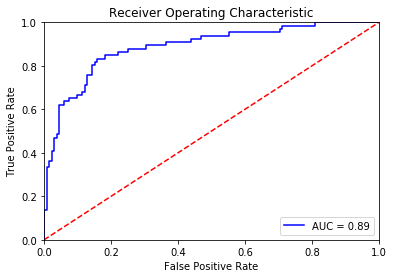

In [16]:

oos_predictions = pipe.predict([r[0] for r in hpv_test])
oos_predicted_probabilities = pipe.predict_proba([r[0] for r in hpv_test])


performance(oos_predictions, [e[1] for e in hpv_test])
roc_curve(oos_predicted_probabilities, [e[1] for e in hpv_test])

... but maybe here it's actually better if we used the adapted probabilities

In [17]:
oos_predictions_new = np.where(oos_predicted_probabilities[:,1] > optimal_threshold, 1, 0)

print('\n\nWITH THRESHOLD OF {}'.format(np.exp(optimal_threshold)))
performance(oos_predictions_new, [e[1] for e in hpv_test])



WITH THRESHOLD OF 1.5476699963837433
Accuracy: 0.8181818181818182 
Recall (misinfo): 0.6515151515151515 
Precision (misinfo): 0.7678571428571429 
Recall (legitimate): 0.9015151515151515 
Precision (legitimate)  0.8380281690140845 
Confusion Matrix: 
 [[119  13]
 [ 23  43]]
